In [ ]:
# imports
import csv
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.signal as signal
from matplotlib.colors import Normalize
from dateutil.relativedelta import relativedelta

In [11]:
# load in datasets
cropland_ndvi_path_fmt = r'../data/cropland_ndvi/{}/'
unfiltered_ndvi_path_fmt = r'../data/modis_ndvi/{}/'
cropland_precip_path_fmt = r'../data/cropland_rainfall/{}/'
unfiltered_precip_path_fmt = r'../data/precipitation/{}/'
smoothed_path_fmt = r'../data/smoothed_data/{}_{}.csv'
format_string = r'%b %d, %Y'
datasets = {
    'KE05': [unfiltered_ndvi_path_fmt.format('KE05'), unfiltered_precip_path_fmt.format('KE05')],
    'KE09': [unfiltered_ndvi_path_fmt.format('KE09'), unfiltered_precip_path_fmt.format('KE09')],
    'KE16': [cropland_ndvi_path_fmt.format('KE16'), cropland_precip_path_fmt.format('KE16')],
}
datasets = {
    'eljadida': [unfiltered_ndvi_path_fmt.format('eljadida'), unfiltered_precip_path_fmt.format('eljadida')],
    'safi': [unfiltered_ndvi_path_fmt.format('safi'), unfiltered_precip_path_fmt.format('safi')],
    'khouribga': [unfiltered_ndvi_path_fmt.format('khouribga'), unfiltered_precip_path_fmt.format('khouribga')]
}
ts_dct = {region: [TimeSeries(paths[0], format_string), 
                   TimeSeries(paths[1], format_string)] for region, paths in datasets.items()}

In [12]:
# interpolate, lockstep, and smooth the data sets, then export them all to a file
kernel_len = 90
kernel_std = 10
window = signal.windows.gaussian(kernel_len, kernel_std)

new_ts_dct = {}

for zone, ts_lst in ts_dct.items():
    ndvi_ts, precip_ts = ts_lst[0], ts_lst[1]
    start = max(ndvi_ts.dates[0], precip_ts.dates[0])
    end = min(ndvi_ts.dates[-1], precip_ts.dates[-1])
    step = relativedelta(days = 1)

    resampled_ndvi = ndvi_ts.resample(start, end, step)
    smoothed_ndvi = resampled_ndvi.smooth(window)

    resampled_precip = precip_ts.resample(start, end, step)
    smoothed_precip = resampled_precip.smooth(window)

    new_ts_dct[zone] = [smoothed_ndvi, smoothed_precip]

    data_dir = smoothed_path_fmt.format(zone, kernel_std)
    assert smoothed_ndvi.dates == smoothed_precip.dates
    with open(data_dir, 'w', newline='') as f:
        wr = csv.writer(f)
        wr.writerow(['date', 'ndvi', 'precip'])
        for date, ndvi, precip in zip(smoothed_ndvi.dates, smoothed_ndvi.x, smoothed_precip.x):
            date_str = date.strftime(format_string)
            wr.writerow([date_str, ndvi, precip])

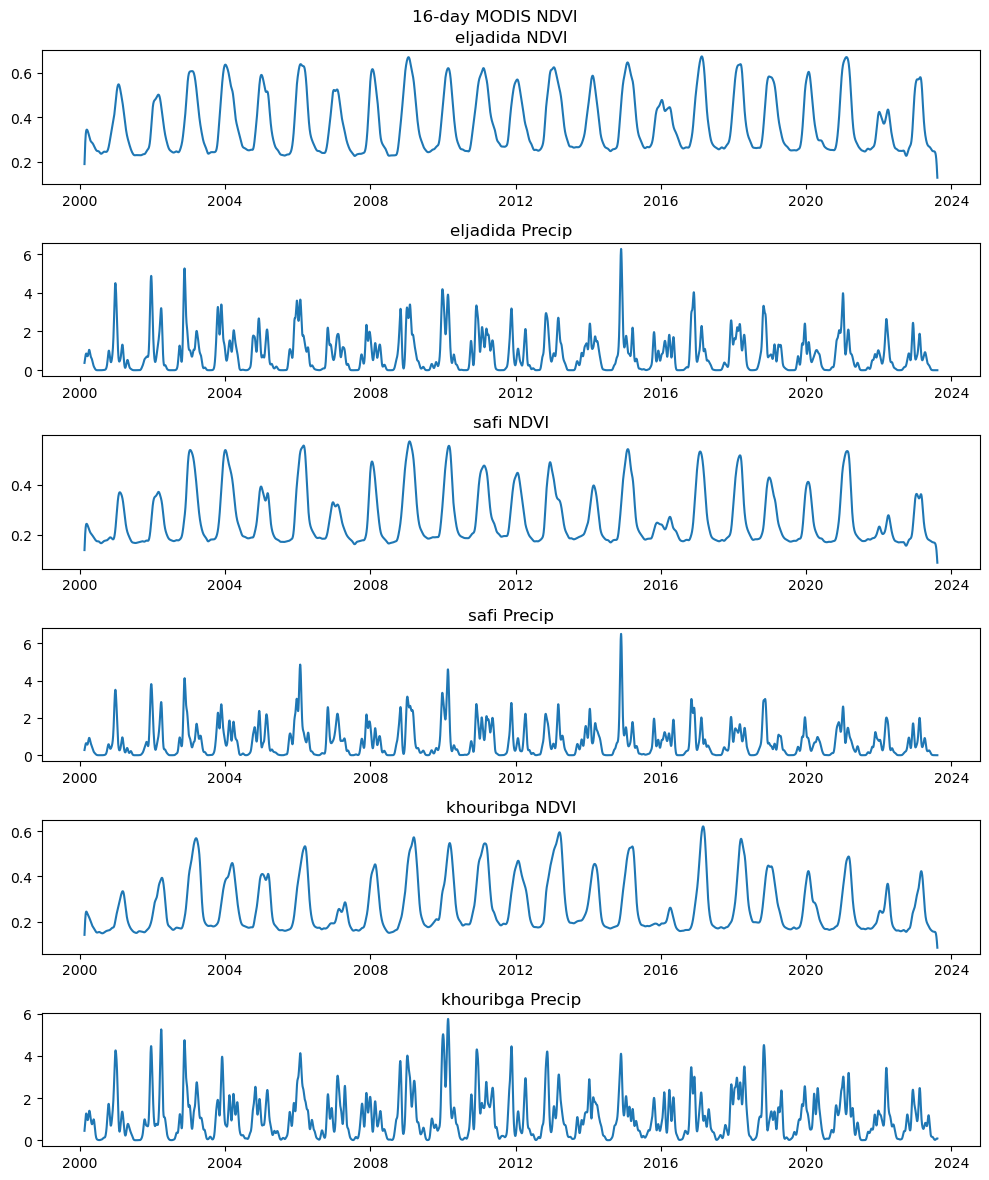

In [13]:
# plots
n_regions = len(ts_dct)
fig, axs = plt.subplots(2 * n_regions, 1)
fig.set_figheight(4 * n_regions)
fig.set_figwidth(10)
for k, (zone, ts_lst) in enumerate(new_ts_dct.items()):
    ndvi, precip = ts_lst[0], ts_lst[1]

    ndvi_ax = axs[2*k]
    precip_ax = axs[2*k+1]
    ndvi_ax.plot(ndvi.dates, ndvi.x)
    ndvi_ax.set_title(f'{zone} NDVI')
    precip_ax.plot(precip.dates, precip.x)
    precip_ax.set_title(f'{zone} Precip')
    
fig.suptitle('16-day MODIS NDVI')
fig.tight_layout()